The notebook **Angika_Translation_Model.ipynb** contains a sequence of Python code cells primarily aimed at loading data, preprocessing it, and using it to train a machine translation model. Below is a description of the tasks performed by the cells:

**Environment Setup and Library Importation:**
Sets up the Python environment and imports necessary libraries such as numpy, pandas, and keras.
Lists files in a specified directory, useful for ensuring data availability.

**Data Loading:**
Loads a dataset from an Excel file containing multilingual data for translation tasks.

**Data Preprocessing:**
Filters rows based on a specific condition (e.g., where 'Label' equals 'Social').
Displays a subset of the data and checks for missing values.

**Model Building and Compilation:**
Sets up a sequential model including LSTM layers for the task of machine translation.
Compiles the model specifying the optimizer and loss function.

**Training Preparation:**
Prepares training data, including tokenization and encoding.

**Model Training:**
Trains the model on the preprocessed data and validates it using a separate validation set.

**Prediction and Evaluation:**
Generates predictions for a batch of data and prints out the input, actual, and predicted translations to evaluate model performance.

In [ ]:
import numpy as np
import pandas as pd
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Use tf.keras (not standalone keras)
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense  # type: ignore
from tensorflow.keras.models import Model  # type: ignore

print("✅ Setup Complete")


TensorFlow version: 2.18.0
✅ Setup Complete


In [ ]:
# List files in the data directory to verify availability
print(os.listdir("/content/drive/MyDrive/Angika-LowResource-Translator/data/"))

['Angika GPT.xlsx']


In [ ]:
# Improve DataFrame display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)  # Display full text in columns

# Note: All outputs will be written to current directory if using file writes


In [ ]:
lines = pd.read_excel("/content/drive/MyDrive/Angika-LowResource-Translator/data/Angika GPT.xlsx")
print(lines)

          ID                                                                     Angika                                                                                  English
0          1                   लोक व्यवहार में जे भाषा के प्रयोग होय है वहे भाषा छिकै ।                                      The language used in folk practice is the language.
1          2                             यही लेलो, विशिष्ट लोगों के वाणी भाषा नै छिकै ।                                 Therefore, the speech of the minorities is not language.
2          3               जे भाषा साधारण जन-जाति प्रयोग करें, वह मूलतः भाषा कहलावे है।                  The language used by the common people is called the original language.
3          4                                           भाषा विज्ञान केरों भी यहै मत है।                                             This is also the case with language imaging.
4          5                                               भाषा अत्यन्त व्यापक शब्द है।                            

In [ ]:
# Display first 20 rows for inspection
lines.head(20)

# Optional: Print shape if needed
print("Total rows:", lines.shape[0])


Total rows: 45555


In [ ]:
pd.isnull(lines).sum()[pd.isnull(lines).sum() > 0]


,0
Angika,7
English,235


In [ ]:
lines[lines.isnull().any(axis=1)]


In [ ]:
# Remove rows where 'Angika' is null
lines = lines[~pd.isnull(lines['Angika'])]

In [ ]:
# Drop duplicate Angika sentences
lines.drop_duplicates(subset=['Angika'], inplace=True)

In [ ]:
before = len(lines)
lines = lines[~pd.isnull(lines['Angika'])]
lines.drop_duplicates(subset=['Angika'], inplace=True)
after = len(lines)
print(f"Cleaned dataset. Remaining rows: {after} (Removed {before - after} rows)")


Cleaned dataset. Remaining rows: 41656 (Removed 0 rows)


In [ ]:
lines=lines.sample(n=400,random_state=5)
# ⚠️ Optional: Safety check before sampling
assert lines.shape[0] >= 400, "Not enough rows to sample 400"
lines.shape
# ✅ Optional: Print the shape for visibility
print("Sampled data shape:", lines.shape)


Sampled data shape: (400, 3)


In [ ]:
# ✅ Step: Check if the DataFrame is empty
if lines.empty:
    print("DataFrame is empty. Cannot sample.")

else:
    # ✅ Step: Choose sample size safely (max 45,000 or total available rows)
    sample_size = min(45000, len(lines))

    # 🎯 Step: Sample the data randomly but reproducibly
    lines = lines.sample(n=sample_size, random_state=5)

    # 📊 Step: Confirm the new shape of the sampled DataFrame
    print("Sampled data shape:", lines.shape)


Sampled data shape: (400, 3)


In [ ]:
# ✅ Safely convert all Angika and English text to lowercase
lines['Angika'] = lines['Angika'].astype(str).str.lower()
lines['English'] = lines['English'].astype(str).str.lower()


In [ ]:
import re  # make sure you've already imported this

lines['Angika'] = lines['Angika'].astype(str).str.replace(r"[\"']", '', regex=True)
lines['English'] = lines['English'].astype(str).str.replace(r"[\"']", '', regex=True)


In [ ]:
import string

# ✅ Create a set of all punctuation characters
exclude = set(string.punctuation)

# ✅ Remove all punctuation from 'Angika' and 'English' columns
lines['Angika'] = lines['Angika'].astype(str).apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['English'] = lines['English'].astype(str).apply(lambda x: ''.join(ch for ch in x if ch not in exclude))


In [ ]:
import re

# ✅ Remove punctuation using regex
lines['Angika'] = lines['Angika'].astype(str).str.replace(r'[^\w\s]', '', regex=True)
lines['English'] = lines['English'].astype(str).str.replace(r'[^\w\s]', '', regex=True)



In [ ]:
# Add start and end tokens to target sequences
lines['English'] = lines['English'].apply(lambda x : f'START_ {x.strip()} _END')


In [ ]:
lines.head()

,ID,Angika,English
25390,25391,सरपत क चहर मलन ह जन कहस बच चनरम करण सरव र दपदय दप भद पडव आर पनरम,START_ indras face was pale like the moon amidst mist while karna shone like the sun piercing through the clouds _END
30571,30572,मत मर,START_ beaten mother _END
18609,18610,दकखन दजञ गठ पर डप पतत जगवर क दज सट स क दडन जर हमन,START_ on the southern side of the pit the joggers continued running _END
44442,44443,पसकस pisces,START_ pisces _END
32002,32003,कगजपततर,START_ paper and leaves _END


In [ ]:
# Angika Vocabulary
all_Angika_words = {word for sentence in lines['Angika'] for word in sentence.split()}

# English Vocabulary
all_Eng_words = {word for sentence in lines['English'] for word in sentence.split()}


In [ ]:
print("Unique Angika words:", len(all_Angika_words))
print("Unique English words:", len(all_Eng_words))


Unique Angika words: 1490
Unique English words: 1564


In [ ]:
lines['length_Angika_sentence'] = lines['Angika'].str.split().str.len()
lines['length_Eng_sentence'] = lines['English'].str.split().str.len()

In [ ]:
lines.head()

,ID,Angika,English,length_Angika_sentence,length_Eng_sentence
25390,25391,सरपत क चहर मलन ह जन कहस बच चनरम करण सरव र दपदय दप भद पडव आर पनरम,START_ indras face was pale like the moon amidst mist while karna shone like the sun piercing through the clouds _END,18,21
30571,30572,मत मर,START_ beaten mother _END,2,4
18609,18610,दकखन दजञ गठ पर डप पतत जगवर क दज सट स क दडन जर हमन,START_ on the southern side of the pit the joggers continued running _END,15,13
44442,44443,पसकस pisces,START_ pisces _END,2,3
32002,32003,कगजपततर,START_ paper and leaves _END,1,5


📊 Visualize Sentence Lengths

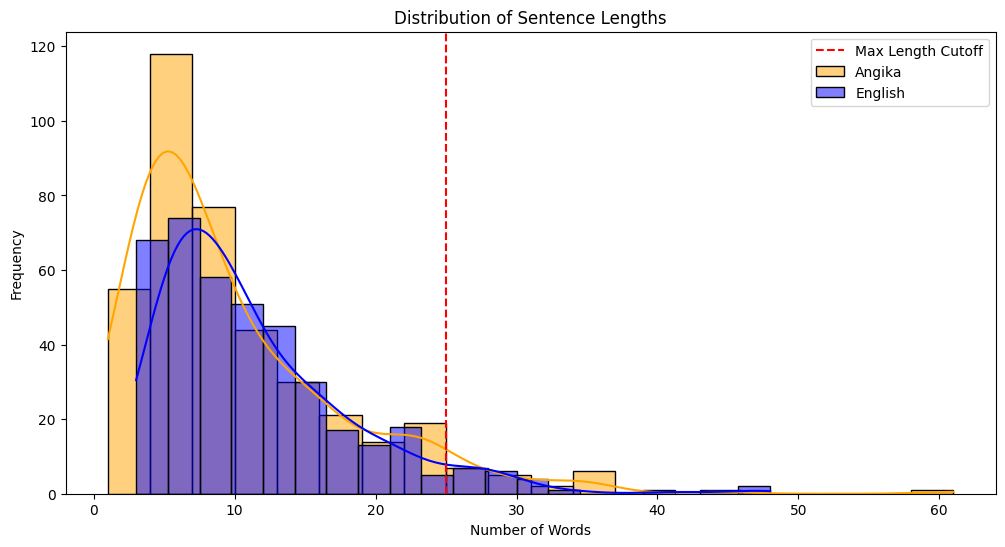

90th percentile Angika length: 22.0
90th percentile English length: 21.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(lines['length_Angika_sentence'], bins=20, color='orange', label='Angika', kde=True)
sns.histplot(lines['length_Eng_sentence'], bins=20, color='blue', label='English', kde=True)

# Add vertical line for max length cutoff
plt.axvline(x=25, color='red', linestyle='--', label='Max Length Cutoff')

plt.legend()
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Print 90th percentile of sentence lengths
print("90th percentile Angika length:", lines['length_Angika_sentence'].quantile(0.90))
print("90th percentile English length:", lines['length_Eng_sentence'].quantile(0.90))


1. 📊 Check Distribution of Sentence Lengths

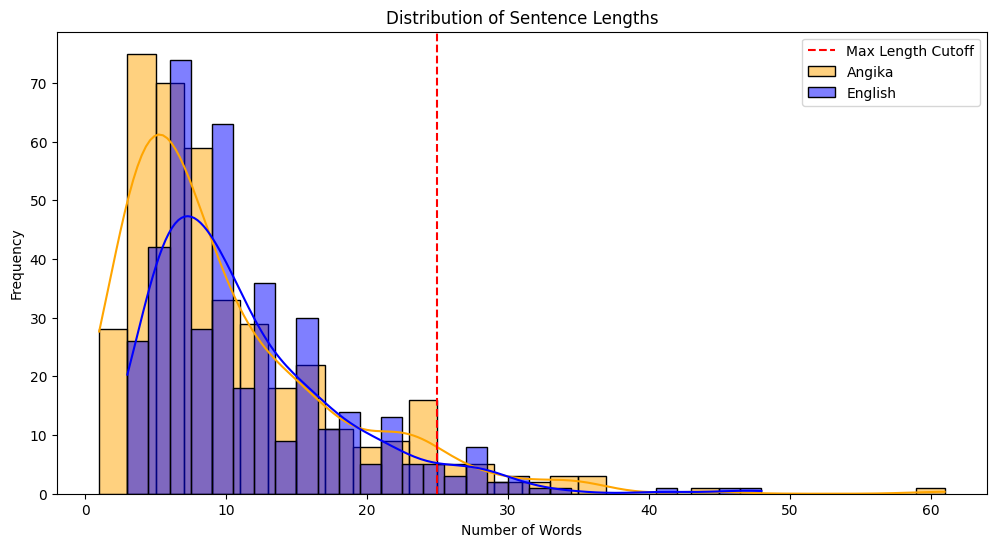

90% of Angika sentences have <=  22.0  words
90% of English sentences have <=  21.0  words
Filtered dataset size: (373, 5)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram with KDE
plt.figure(figsize=(12,6))
sns.histplot(lines['length_Angika_sentence'], bins=30, color='orange', label='Angika', kde=True)
sns.histplot(lines['length_Eng_sentence'], bins=30, color='blue', label='English', kde=True)

# Vertical line for visual max threshold
plt.axvline(x=25, color='red', linestyle='--', label='Max Length Cutoff')

plt.legend()
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Print 90th percentile
print("90% of Angika sentences have <= ", lines['length_Angika_sentence'].quantile(0.90), " words")
print("90% of English sentences have <= ", lines['length_Eng_sentence'].quantile(0.90), " words")

# Define cutoffs
MAX_ANGIKA_LEN = 25
MAX_ENG_LEN = 25

# Filter long sentences
lines = lines[
    (lines['length_Angika_sentence'] <= MAX_ANGIKA_LEN) &
    (lines['length_Eng_sentence'] <= MAX_ENG_LEN)
].reset_index(drop=True)

print("Filtered dataset size:", lines.shape)




In [ ]:
# 👀 Check how many long Angika sentences exist (sanity check)
print("Angika sentences > 30 words:", lines[lines['length_Angika_sentence'] > 30].shape)

Angika sentences > 30 words: (0, 5)


In [ ]:
# ✅ Keep only sentences ≤ 20 words
lines = lines[
    (lines['length_Angika_sentence'] <= 20) &
    (lines['length_Eng_sentence'] <= 20)
]

In [ ]:
# 🧾 Show new dataset shape
print("Filtered dataset shape:", lines.shape)

Filtered dataset shape: (341, 5)


In [ ]:
# 🔍 Confirm the new max lengths
print("Maximum length of Angika Sentence:", max(lines['length_Angika_sentence']))
print("Maximum length of English Sentence:", max(lines['length_Eng_sentence']))


Maximum length of Angika Sentence: 20
Maximum length of English Sentence: 20


In [ ]:
# 📌 Store them for padding later
max_length_src = max(lines['length_Angika_sentence'])
max_length_tar = max(lines['length_Eng_sentence'])

In [ ]:
# 📖 Vocabulary preparation
input_words = sorted(list(all_Angika_words))
target_words = sorted(list(all_Eng_words))

# ⚠️ Filter words in your vocab based on the filtered dataset!
# Otherwise, all_Angika_words and all_Eng_words might include discarded rows.
# Consider rebuilding vocab here if needed.

num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)

# ✅ Add 1 for zero-padding token
num_decoder_tokens += 1

print("Number of encoder tokens:", num_encoder_tokens)
print("Number of decoder tokens (with padding):", num_decoder_tokens)

Number of encoder tokens: 1490
Number of decoder tokens (with padding): 1565


In [ ]:
# 🔄 Word to index mapping
input_token_index = dict([(word, i + 1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i + 1) for i, word in enumerate(target_words)])

In [ ]:
# 📌 Reverse dictionary for decoding predictions later
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
# 🔀 Shuffle and preview data
from sklearn.utils import shuffle
lines = shuffle(lines)
lines = lines.reset_index(drop=True)
print(lines.head(10))

      ID                                                            Angika                                                                                          English  length_Angika_sentence  length_Eng_sentence
0   7535                                      सवरजय न ऊपर स टपक जन ल सब कय                           START_ if selfrule is imposed from above everyone will understand _END                       9                   11
1  26756                                   समपरण सटट क बरषक आय 20 लख रपय ह                                   START_ the annual income of the state is 2 million rupees _END                       9                   12
2    462  यदयप ई परयस बहत छट ह आर खड आद क करय परय अनमन पर आधरत ह आर अशदध ह  START_ although this attempt is very small and mostly based on speculation it is incorrect _END                      19                   16
3  24254                                            ई सन क सब अवक रह गल छल                                                    START_

In [ ]:
# ✂️ Train-test split
from sklearn.model_selection import train_test_split
X, y = lines['Angika'], lines['English']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (272,)
Test shape: (69,)


In [ ]:
# 💾 Save for future reuse
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [ ]:
import numpy as np

def generate_batch(X=X_train, y=y_train, batch_size=128):
    '''Generate batches of (encoder_input, decoder_input), decoder_target'''
    while True:
        for j in range(0, len(X), batch_size):
            # 👇 Get batch slice
            X_batch = X[j:j+batch_size]
            y_batch = y[j:j+batch_size]

            # 👇 Dynamic batch size (for last batch which may be smaller)
            current_batch_size = len(X_batch)

            # 🧠 Initialize zero matrices
            encoder_input_data = np.zeros((current_batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((current_batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((current_batch_size, max_length_tar, num_decoder_tokens), dtype='float32')

            for i, (input_text, target_text) in enumerate(zip(X_batch, y_batch)):
                input_words = input_text.split()
                target_words = target_text.split()

                # 🔢 Fill encoder sequence
                for t, word in enumerate(input_words):
                    if word in input_token_index:
                        encoder_input_data[i, t] = input_token_index[word]

                # 🔢 Fill decoder input and target sequence
                for t, word in enumerate(target_words):
                    if word in target_token_index:
                        if t < max_length_tar:
                            decoder_input_data[i, t] = target_token_index[word]
                        if t > 0 and (t - 1) < max_length_tar:
                            # Target is ahead by 1 timestep
                            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0

            yield ([encoder_input_data, decoder_input_data], decoder_target_data)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

latent_dim = 300  # LSTM units (dimensionality of hidden state)

# 🔷 Encoder
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
enc_emb = Embedding(input_dim=num_encoder_tokens + 1, output_dim=latent_dim, mask_zero=True, name='encoder_embedding')(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# 🔶 Decoder
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
dec_emb_layer = Embedding(input_dim=num_decoder_tokens + 1, output_dim=latent_dim, mask_zero=True, name='decoder_embedding')
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

# 🔧 Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 🧠 Compile
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 📝 Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 300) │    447,300 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 300) │    469,800 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 300),     │    721,200 │ encoder_embeddin… │
│                     │ (None, 300),      │            │ not_equal_2[0][0] │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    721,200 │ decoder_embeddin… │
│                     │ 300), (None,      │            │ encoder_lstm[0][… │
│                     │ 300), (None,      │            │ encoder_lstm[0][… │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, None,      │    471,065 │ decoder_lstm[0][… │
│ (Dense)             │ 1565)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,830,565 (10.80 MB)

 Trainable params: 2,830,565 (10.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_samples = len(X_train)
print(train_samples)
val_samples = len(X_test)
print(val_samples)
batch_size =8
epochs = 100

272
69


In [ ]:
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

# ⚙️ Hyperparameters
batch_size = 8
epochs = 100
embedding_dim = 256
latent_dim = 256

# 🧾 Pre-requisite: You must define these before training
# Assume these are already computed from your preprocessing steps
# input_token_index, target_token_index, X_train, y_train, X_test, y_test

# 🔢 Size Definitions
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)
max_length_src = max([len(text.split()) for text in X_train])
max_length_tar = max([len(text.split()) for text in y_train])

# 🔁 Custom Batch Generator
def generate_batch(X, y, batch_size=128):
    while True:
        for j in range(0, len(X), batch_size):
            curr_batch_size = len(X[j:j+batch_size])
            encoder_input_data = np.zeros((curr_batch_size, max_length_src), dtype='int32')
            decoder_input_data = np.zeros((curr_batch_size, max_length_tar), dtype='int32')
            decoder_target_data = np.zeros((curr_batch_size, max_length_tar, num_decoder_tokens), dtype='float32')

            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                input_seq = input_text.split()
                target_seq = target_text.split()

                for t, word in enumerate(input_seq):
                    if t < max_length_src:
                        encoder_input_data[i, t] = input_token_index.get(word, 0)

                for t, word in enumerate(target_seq):
                    if t < max_length_tar:
                        decoder_input_data[i, t] = target_token_index.get(word, 0)
                    if t > 0 and t - 1 < max_length_tar:
                        decoder_target_data[i, t - 1, target_token_index.get(word, 0)] = 1.0

            yield (encoder_input_data, decoder_input_data), decoder_target_data

# 📐 Dataset Info
train_samples = len(X_train)
val_samples = len(X_test)
steps_per_epoch = math.ceil(train_samples / batch_size)
validation_steps = math.ceil(val_samples / batch_size)

# 🧱 Dataset API from Generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: generate_batch(X_train, y_train, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, max_length_src), dtype=tf.int32),
            tf.TensorSpec(shape=(None, max_length_tar), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, max_length_tar, num_decoder_tokens), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_batch(X_test, y_test, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, max_length_src), dtype=tf.int32),
            tf.TensorSpec(shape=(None, max_length_tar), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, max_length_tar, num_decoder_tokens), dtype=tf.float32)
    )
)

# 🧠 Encoder
encoder_inputs = Input(shape=(None,))
enc_emb_layer = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim, mask_zero=True)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, unroll=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# 🧠 Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(input_dim=num_decoder_tokens, output_dim=embedding_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, unroll=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 🔧 Compile & Train Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 Training
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

# 💾 Save Trained Weights
model.save_weights('nmt_weights.weights.h5')


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.0441 - loss: 6.3530 - val_accuracy: 0.0500 - val_loss: 5.6472
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.0514 - loss: 5.4610 - val_accuracy: 0.0710 - val_loss: 5.5874
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0608 - loss: 5.2166 - val_accuracy: 0.0725 - val_loss: 5.6188
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0644 - loss: 5.1214 - val_accuracy: 0.0725 - val_loss: 5.6547
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0650 - loss: 5.0587 - val_accuracy: 0.0725 - val_loss: 5.6912
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0642 - loss: 5.0066 - val_accuracy: 0.0732 - val_loss: 5.7194
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0645 - loss: 4.9553 - val_accuracy: 0.0746 - val_loss: 5.7361
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0646 - loss: 4.9045 - val_accuracy: 0.0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import numpy as np

# ✅ Reverse the target_token_index to get index → word mapping
reverse_target_token_index = dict((i, word) for word, i in target_token_index.items())

# ✅ 1. Encoder Inference Model
encoder_model = Model(encoder_inputs, encoder_states)

# ✅ 2. Decoder Inference Model
decoder_state_input_h = Input(shape=(latent_dim,), name="input_h")
decoder_state_input_c = Input(shape=(latent_dim,), name="input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 🔁 Inference decoder input (new Input layer with batch size 1)
decoder_inputs_inf = Input(shape=(1,), name="decoder_input_infer")
dec_emb_inf = dec_emb_layer(decoder_inputs_inf)

# 🔁 Decoder output and state updates
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb_inf, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# ✅ Final decoder inference model
decoder_model = Model(
    [decoder_inputs_inf] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

# ✅ 3. Decoding Function
def decode_sequence(input_seq):
    # Encode the input sentence to get initial states
    states_value = encoder_model.predict(input_seq)

    # Start with the START_ token
    target_seq = np.zeros((1, 1), dtype='int32')
    target_seq[0, 0] = target_token_index['START_']

    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        # Predict next token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample predicted token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_token_index.get(sampled_token_index, '')

        if sampled_word == '_END' or len(decoded_sentence.split()) > max_length_tar:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update target_seq and states
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# ✅ 4. Pick a Test Sentence and Translate
train_gen = generate_batch(X_train, y_train, batch_size=1)
(input_seq, actual_output), _ = next(train_gen)

# Translate
decoded_sentence = decode_sequence(input_seq)

# ✅ 5. Show Input / Target / Prediction
k = 0
print('🔤 Input Angika sentence:', X_train.iloc[k])
print('✅ Actual English Translation:', y_train.iloc[k][6:-4])  # Remove START_/_END
print('🤖 Predicted English Translation:', decoded_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🔤 Input Angika sentence: आर आख मनल कलडय म कहतक
✅ Actual English Translation:  saying in a closedeyed way 
🤖 Predicted English Translation: saying in a closedeyed way


In [ ]:
# 🔄 Generator for single-sample batches
train_gen = generate_batch(X_train, y_train, batch_size=1)

# 🔁 Loop through first N samples
N = 5  # Change this to how many examples you want
for i in range(N):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)

    print(f"\n🔢 Example {i+1}")
    print("🔤 Input Angika sentence:", X_train.iloc[i])
    print("✅ Actual English Translation:", y_train.iloc[i][6:-4])  # Remove START_/END
    print("🤖 Predicted English Translation:", decoded_sentence.replace('_END', '').strip())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

🔢 Example 1
🔤 Input Angika sentence: आर आख मनल कलडय म कहतक
✅ Actual English Translation:  saying in a closedeyed way 
🤖 Predicted English Translation: saying in a closedeyed way
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

🔢 Example 2
🔤 Input Angika sentence: फरल बर जय
✅ Actual English Translation:  it could be returned 
🤖 Predicted English Translation: it could be returned
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━